In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from data import RoadSatelliteModule
from system import SemanticSegmentationSystem

from models import *

import numpy as np
import matplotlib.pyplot as plt
import random

import torchvision
import torchvision.transforms.functional as F

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping

import torch
from torchinfo import summary

# 1. Preparation

In [3]:
batch_size = 8
num_workers = 8

In [4]:
pl.seed_everything(33, workers=True)

Global seed set to 33


33

## 1.1 DataModule

In [5]:
road_data = RoadSatelliteModule()

In [6]:
%%time
X, y = next(iter(road_data.train_dataloader()))

CPU times: user 2.7 s, sys: 1.32 s, total: 4.02 s
Wall time: 4.46 s


In [7]:
X.shape

torch.Size([8, 3, 160, 160])

## 1.2 Inspect Data

In [8]:
def show_image(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

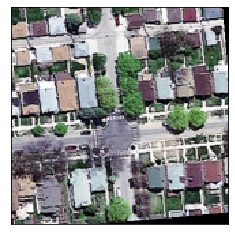

In [9]:
show_image(X[0])

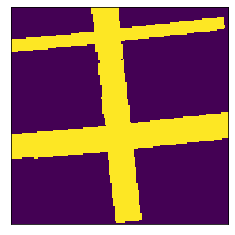

In [10]:
show_image(y[0])

# 2. Define Model / System

In [26]:
model = UNet_3Plus_Spatial_Dialated(n_classes=1)

In [27]:
system = SemanticSegmentationSystem(model, road_data)

In [28]:
summary(model, input_size=X.shape)

Layer (type:depth-idx)                                  Output Shape              Param #
UNet_3Plus_Spatial_Dialated                             --                        --
├─unetConv2Dialated: 1-1                                [8, 64, 160, 160]         --
│    └─Sequential: 2-1                                  [8, 64, 160, 160]         --
│    │    └─Conv2d: 3-1                                 [8, 64, 160, 160]         1,792
│    │    └─BatchNorm2d: 3-2                            [8, 64, 160, 160]         128
│    │    └─ReLU: 3-3                                   [8, 64, 160, 160]         --
│    └─Conv2d: 2-2                                      [8, 32, 160, 160]         18,464
│    └─BatchNorm2d: 2-3                                 [8, 32, 160, 160]         64
│    └─ReLU: 2-4                                        [8, 32, 160, 160]         --
│    └─Conv2d: 2-5                                      [8, 16, 160, 160]         4,624
│    └─BatchNorm2d: 2-6                          

In [29]:
if torch.cuda.is_available():
    gpu_count = -1
    gpu_auto_select = True
    print("GPUs detected.")
    print("There should be ", torch.cuda.device_count(), " GPUs available.")
else:
    gpu_count = 0
    gpu_auto_select = False
    print("No GPU detected.")
    print("Working with CPU")

gpu_count

GPUs detected.
There should be  1  GPUs available.


-1

# 4. Training

In [30]:
early_stop_callback = EarlyStopping(
   monitor='validation_accuracy',
   patience=20,
   verbose=2,
   mode='max'
)

In [31]:
trainer = pl.Trainer(
    #fast_dev_run=True,
    gpus=gpu_count,
    auto_select_gpus=gpu_auto_select,
    stochastic_weight_avg=True,
    benchmark=True,
    callbacks=[early_stop_callback]
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [32]:
%%time
trainer.fit(system)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                        | Params
----------------------------------------------------------
0 | model     | UNet_3Plus_Spatial_Dialated | 27.5 M
1 | dice_loss | DiceLoss                    | 0     
----------------------------------------------------------
27.5 M    Trainable params
0         Non-trainable params
27.5 M    Total params
110.076   Total estimated model params size (MB)


Epoch     0: adjusting learning rate of group 0 to 1.0000e-03.


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 33


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric validation_accuracy improved. New best score: 0.761


Epoch     1: adjusting learning rate of group 0 to 9.7555e-04.


Validating: 0it [00:00, ?it/s]

Metric validation_accuracy improved by 0.009 >= min_delta = 0.0. New best score: 0.770


Epoch     2: adjusting learning rate of group 0 to 9.0460e-04.


Validating: 0it [00:00, ?it/s]

Epoch     3: adjusting learning rate of group 0 to 7.9410e-04.


Validating: 0it [00:00, ?it/s]

Metric validation_accuracy improved by 0.024 >= min_delta = 0.0. New best score: 0.793


Epoch     4: adjusting learning rate of group 0 to 6.5485e-04.


Validating: 0it [00:00, ?it/s]

Epoch     5: adjusting learning rate of group 0 to 5.0050e-04.


Validating: 0it [00:00, ?it/s]

Metric validation_accuracy improved by 0.012 >= min_delta = 0.0. New best score: 0.806


Epoch     6: adjusting learning rate of group 0 to 3.4615e-04.


Validating: 0it [00:00, ?it/s]

Epoch     7: adjusting learning rate of group 0 to 2.0690e-04.


Validating: 0it [00:00, ?it/s]

Metric validation_accuracy improved by 0.012 >= min_delta = 0.0. New best score: 0.817


Epoch     8: adjusting learning rate of group 0 to 9.6396e-05.


Validating: 0it [00:00, ?it/s]

Metric validation_accuracy improved by 0.009 >= min_delta = 0.0. New best score: 0.826


Epoch     9: adjusting learning rate of group 0 to 2.5447e-05.


Validating: 0it [00:00, ?it/s]

Metric validation_accuracy improved by 0.007 >= min_delta = 0.0. New best score: 0.833


Epoch    10: adjusting learning rate of group 0 to 1.0000e-03.


Validating: 0it [00:00, ?it/s]

Epoch    11: adjusting learning rate of group 0 to 9.9385e-04.


Validating: 0it [00:00, ?it/s]

Epoch    12: adjusting learning rate of group 0 to 9.7555e-04.


Validating: 0it [00:00, ?it/s]

Epoch    13: adjusting learning rate of group 0 to 9.4556e-04.


Validating: 0it [00:00, ?it/s]

Metric validation_accuracy improved by 0.024 >= min_delta = 0.0. New best score: 0.856


Epoch    14: adjusting learning rate of group 0 to 9.0460e-04.


Validating: 0it [00:00, ?it/s]

Epoch    15: adjusting learning rate of group 0 to 8.5370e-04.


Validating: 0it [00:00, ?it/s]

Metric validation_accuracy improved by 0.009 >= min_delta = 0.0. New best score: 0.865


Epoch    16: adjusting learning rate of group 0 to 7.9410e-04.


Validating: 0it [00:00, ?it/s]

Epoch    17: adjusting learning rate of group 0 to 7.2727e-04.


Validating: 0it [00:00, ?it/s]

Epoch    18: adjusting learning rate of group 0 to 6.5485e-04.


Validating: 0it [00:00, ?it/s]

Epoch    19: adjusting learning rate of group 0 to 5.7864e-04.


Validating: 0it [00:00, ?it/s]

Metric validation_accuracy improved by 0.025 >= min_delta = 0.0. New best score: 0.890


Epoch    20: adjusting learning rate of group 0 to 5.0050e-04.


Validating: 0it [00:00, ?it/s]

Epoch    21: adjusting learning rate of group 0 to 4.2236e-04.


Validating: 0it [00:00, ?it/s]

Epoch    22: adjusting learning rate of group 0 to 3.4615e-04.


Validating: 0it [00:00, ?it/s]

Metric validation_accuracy improved by 0.006 >= min_delta = 0.0. New best score: 0.897


Epoch    23: adjusting learning rate of group 0 to 2.7373e-04.


Validating: 0it [00:00, ?it/s]

Epoch    24: adjusting learning rate of group 0 to 2.0690e-04.


Validating: 0it [00:00, ?it/s]

Epoch    25: adjusting learning rate of group 0 to 1.4730e-04.


Validating: 0it [00:00, ?it/s]

Epoch    26: adjusting learning rate of group 0 to 9.6396e-05.


Validating: 0it [00:00, ?it/s]

Epoch    27: adjusting learning rate of group 0 to 5.5442e-05.


Validating: 0it [00:00, ?it/s]

Epoch    28: adjusting learning rate of group 0 to 2.5447e-05.


Validating: 0it [00:00, ?it/s]

Epoch    29: adjusting learning rate of group 0 to 7.1497e-06.


Validating: 0it [00:00, ?it/s]

Epoch    30: adjusting learning rate of group 0 to 1.0000e-03.


Validating: 0it [00:00, ?it/s]

Epoch    31: adjusting learning rate of group 0 to 9.9846e-04.


Validating: 0it [00:00, ?it/s]

Epoch    32: adjusting learning rate of group 0 to 9.9385e-04.


Validating: 0it [00:00, ?it/s]

Epoch    33: adjusting learning rate of group 0 to 9.8620e-04.


Validating: 0it [00:00, ?it/s]

Epoch    34: adjusting learning rate of group 0 to 9.7555e-04.


Validating: 0it [00:00, ?it/s]

Epoch    35: adjusting learning rate of group 0 to 9.6198e-04.


Validating: 0it [00:00, ?it/s]

Epoch    36: adjusting learning rate of group 0 to 9.4556e-04.


Validating: 0it [00:00, ?it/s]

Epoch    37: adjusting learning rate of group 0 to 9.2639e-04.


Validating: 0it [00:00, ?it/s]

Epoch    38: adjusting learning rate of group 0 to 9.0460e-04.


Validating: 0it [00:00, ?it/s]

Epoch    39: adjusting learning rate of group 0 to 8.8032e-04.


Validating: 0it [00:00, ?it/s]

Epoch    40: adjusting learning rate of group 0 to 8.5370e-04.


Validating: 0it [00:00, ?it/s]

Epoch    41: adjusting learning rate of group 0 to 8.2490e-04.


Validating: 0it [00:00, ?it/s]

Epoch    42: adjusting learning rate of group 0 to 7.9410e-04.


Validating: 0it [00:00, ?it/s]

Monitored metric validation_accuracy did not improve in the last 20 records. Best score: 0.897. Signaling Trainer to stop.


Epoch    43: adjusting learning rate of group 0 to 7.6149e-04.
CPU times: user 6min 1s, sys: 1min 44s, total: 7min 46s
Wall time: 8min 33s


In [36]:
if gpu_count != 0:
    model.cuda()

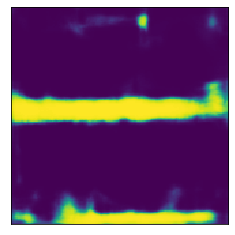

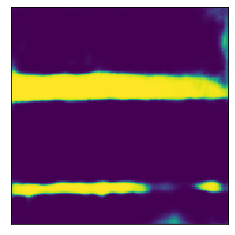

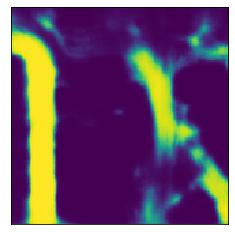

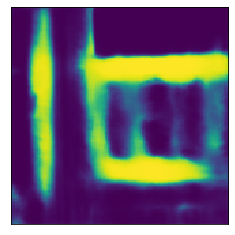

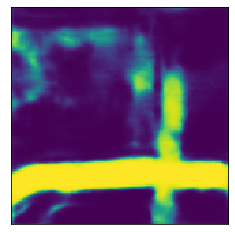

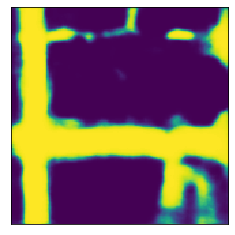

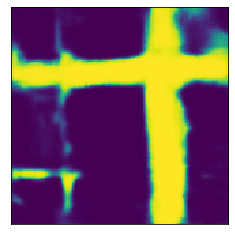

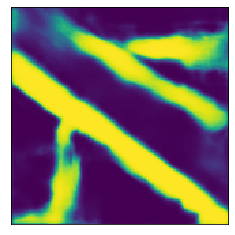

In [37]:
system.visualize_results()

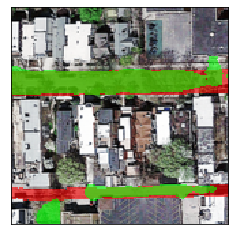

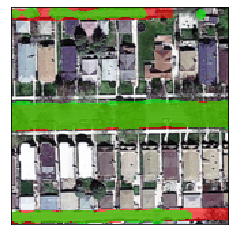

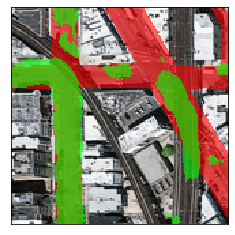

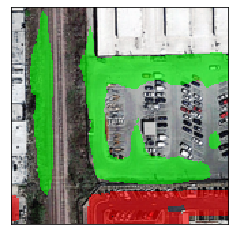

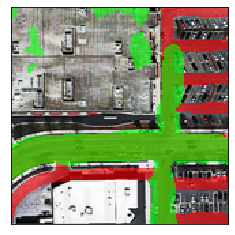

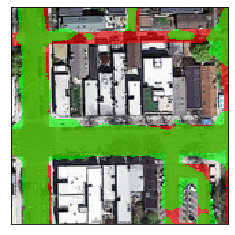

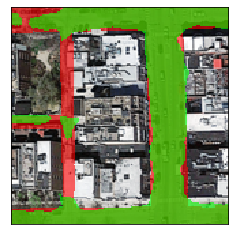

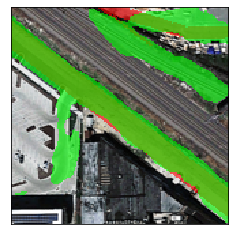

In [38]:
system.visualize_results_overlay()